In [6]:
from ast import literal_eval
from collections import Counter

import fasttext
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [7]:
fasttext.FastText.eprint = lambda x: None # suppress warnings

In [13]:
df_train = pd.read_csv("data_v0.4.2_train.csv")
df_val = pd.read_csv("data_v0.4.2_val.csv")

In [14]:
df_train["sectors"] = df_train["sectors"].apply(literal_eval)
df_train["pillars"] = df_train["pillars"].apply(literal_eval)
df_train["subpillars"] = df_train["subpillars"].apply(literal_eval)
##
df_val["sectors"] = df_val["sectors"].apply(literal_eval)
df_val["pillars"] = df_val["pillars"].apply(literal_eval)
df_val["subpillars"] = df_val["subpillars"].apply(literal_eval)

In [15]:
df_train.columns

Index(['entry_id', 'lead_id', 'project_id', 'project_title',
       'analysis_framework_id', 'excerpt', 'dropped_excerpt', 'created_by_id',
       'modified_by_id', 'verified', 'verification_last_changed_by_id',
       'sectors', 'pillars', 'subpillars'],
      dtype='object')

In [16]:
pils_unique = set()
pils_occurances = list()
for pils in df_train["pillars"]:
    pils_unique.update(pils)
    pils_occurances.extend(pils)
#pils_unique
Counter(pils_occurances).most_common()

[('People At Risk', 43037), ('Impact', 31195), ('Priority Needs', 7217)]

In [17]:
subpils_unique = set()
subpils_occurances = list()
for subpils in df_train["subpillars"]:
    subpils_unique.update(subpils)
    subpils_occurances.extend(subpils)
#subpils_unique
Counter(subpils_occurances).most_common()

[('Living Standards', 18365),
 ('Physical And Mental Well Being', 10803),
 ('Driver/Aggravating Factors', 9490),
 ('Risk And Vulnerabilities', 7784),
 ('Impact On Systems And Services', 5656),
 ('National Response', 5368),
 ('Impact On People', 5130),
 ('International Response', 3844),
 ('Impact On Services', 3735),
 ('Coping Mechanisms', 2832),
 ('Expressed By Humanitarian Staff', 2267),
 ('Impact On People Or Impact On Services', 2100),
 ('Number Of People In Need', 1819),
 ('Number Of People Affected', 1421),
 ('Number Of People Reached', 1261),
 ('Expressed By Population', 1164),
 ('Response Gaps', 246),
 ('Number Of People At Risk', 161)]

In [18]:
secs_unique = set()
secs_occurances = list()
for secs in df_train["sectors"]:
    secs_unique.update(secs)
    secs_occurances.extend(secs)
#secs_unique
Counter(secs_occurances).most_common()

[('Health', 25400),
 ('Cross', 20577),
 ('Protection', 19601),
 ('Livelihoods', 11672),
 ('Food Security', 10585),
 ('WASH', 7982),
 ('Education', 7522),
 ('Shelter', 6815),
 ('Nutrition', 3657),
 ('Agriculture', 2212),
 ('Logistics', 1785)]

In [19]:
!mkdir ft_data

In [22]:
# add columns for sectors
for sector in secs_unique:
    df_train[sector] = 0
# add columns for pillars
for pillar in pils_unique:
    df_train[pillar] = 0
# add columns for subpillars
for subpillar in subpils_unique:
    df_train[subpillar] = 0
##
for row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    sectors_i = row[1]["sectors"]
    pillars_i = row[1]["pillars"]
    subpillars_i = row[1]["subpillars"]
    idx = row[0]
    for sector in sectors_i:
        df_train.loc[idx, sector] = 1
    for pillar in pillars_i:
        df_train.loc[idx, pillar] = 1
    for subpillar in subpillars_i:
        df_train.loc[idx, subpillar] = 1

In [23]:
# add columns for sectors
for sector in secs_unique:
    df_val[sector] = 0
# add columns for pillars
for pillar in pils_unique:
    df_val[pillar] = 0
# add columns for subpillars
for subpillar in subpils_unique:
    df_val[subpillar] = 0
##
for row in tqdm(df_val.iterrows(), total=df_val.shape[0]):
    sectors_i = row[1]["sectors"]
    pillars_i = row[1]["pillars"]
    subpillars_i = row[1]["subpillars"]
    idx = row[0]
    for sector in sectors_i:
        df_val.loc[idx, sector] = 1
    for pillar in pillars_i:
        df_val.loc[idx, pillar] = 1
    for subpillar in subpillars_i:
        df_val.loc[idx, subpillar] = 1

In [24]:
def write_data(X, y, path):
    with open(path, "w") as f:
        for xi, yi in zip(X, y):
            f.write(f"__label__{yi} {xi}\n")


##
def ft_pred(model, X):
    preds = model.predict(X)
    return [int(p[0][9:]) for p in preds[0]]


##
def ft_pred_proba(model, X):
    preds = model.predict(X)
    return [p[0] for p in preds[1]]


##
def train_and_pred_on_sector(df_train, df_val, sector):
    X_train, y_train = df_train["excerpt"].tolist(), df_train[sector].tolist()
    X_val, y_val = df_val["excerpt"].tolist(), df_val[sector].tolist()
    path_train = f"ft_data/{sector}_train.txt"
    path_val = f"ft_data/{sector}_val.txt"
    write_data(X_train, y_train, path_train)
    write_data(X_val, y_val, path_val)
    model = fasttext.train_supervised(input=path_train)
    preds_train = ft_pred(model, X_train)
    preds_val = ft_pred(model, X_val)
    return {
        "y_train": y_train,
        "y_val": y_val,
        "preds_train": preds_train,
        "preds_val": preds_val
    }


def metrics(train_outputs):
    recalls_train, precisions_train, f1_scores_train, supports_train, accuracies_train = [], [], [], [], []
    recalls_val, precisions_val, f1_scores_val, supports_val, accuracies_val = [], [], [], [], []
    sectors = []
    for sector, train_output in train_outputs.items():
        sectors.append(sector)
        ##
        cls_rprt = classification_report(train_output["y_train"],
                                         train_output["preds_train"],
                                         output_dict=True)
        precisions_train.append(cls_rprt["macro avg"]["precision"])
        recalls_train.append(cls_rprt["macro avg"]["recall"])
        f1_scores_train.append(cls_rprt["macro avg"]["f1-score"])
        supports_train.append(cls_rprt["1"]["support"])
        accuracies_train.append(cls_rprt["accuracy"])
        ##
        cls_rprt = classification_report(train_output["y_val"],
                                         train_output["preds_val"],
                                         output_dict=True)
        precisions_val.append(cls_rprt["macro avg"]["precision"])
        recalls_val.append(cls_rprt["macro avg"]["recall"])
        f1_scores_val.append(cls_rprt["macro avg"]["f1-score"])
        supports_val.append(cls_rprt["1"]["support"])
        accuracies_val.append(cls_rprt["accuracy"])
    ##
    metrics_train = pd.DataFrame({
        "Sector": sectors,
        "Precision": precisions_train,
        "Recall": recalls_train,
        "F1 Score": f1_scores_train,
        "Accuracy": accuracies_train,
        "Support": supports_train,
    })
    ##
    metrics_val = pd.DataFrame({
        "Sector": sectors,
        "Precision": precisions_val,
        "Recall": recalls_val,
        "F1 Score": f1_scores_val,
        "Accuracy": accuracies_val,
        "Support": supports_val,
    })
    ##
    return metrics_train, metrics_val


##
def draw_metrics(metrics_df, split_name):
    sns.set(rc={'figure.figsize': (8, 5)})
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 1.2})
    sns.pointplot(x="Sector",
                  y="Recall",
                  data=metrics_df,
                  join=True,
                  color="#d1495b")
    sns.pointplot(x="Sector",
                  y="Precision",
                  data=metrics_df,
                  join=True,
                  color="#edae49")
    sns.pointplot(x="Sector",
                  y="F1 Score",
                  data=metrics_df,
                  join=True,
                  color="#00c2c2")
    sns.pointplot(x="Sector",
                  y="Accuracy",
                  data=metrics_df,
                  join=True,
                  color="#0068bd")
    # "#003d5b"
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title(f"Macro Averaged Metrics on the {split_name} Split")
    markers = [
        plt.Line2D([0, 0], [0, 0], color="#d1495b", marker='o', linestyle=''),
        plt.Line2D([0, 0], [0, 0], color="#edae49", marker='o', linestyle=''),
        plt.Line2D([0, 0], [0, 0], color="#00c2c2", marker='o', linestyle=''),
        plt.Line2D([0, 0], [0, 0], color="#0068bd", marker='o', linestyle=''),
    ]
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(np.arange(0, 1.1, .1))
    plt.legend(markers, [
        "Recall",
        "Precision",
        "F1 Score",
        "Accuracy",
    ])
    plt.show()


##
def draw_supports(metrics_df, split_name):
    sns.set(rc={'figure.figsize': (8, 5)})
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 1.2})
    sns.pointplot(x="Sector",
                  y="Support",
                  data=metrics_df,
                  join=True,
                  color="#003d5b")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title(f"Number of {split_name} Instances")
    plt.xlabel('')
    plt.ylabel('')
    plt.show()


##
# TODO: calc an overall f1 score
def train_and_pred_on_all_sectors(df_train, df_val):
    sectors = [
        'Agriculture',
        'Cross',
        'Education',
        'Food Security',
        'Nutrition',
        'Health',
        'Livelihoods',
        'Logistics',
        'Shelter',
        'Protection',
        'WASH',
    ]
    train_outputs = dict()
    for sector in sectors:
        train_outputs[sector] = train_and_pred_on_sector(
            df_train, df_val, sector)
    return train_outputs

In [25]:
train_outputs = train_and_pred_on_all_sectors(df_train, df_val)

In [26]:
metrics_train, metrics_val = metrics(train_outputs)

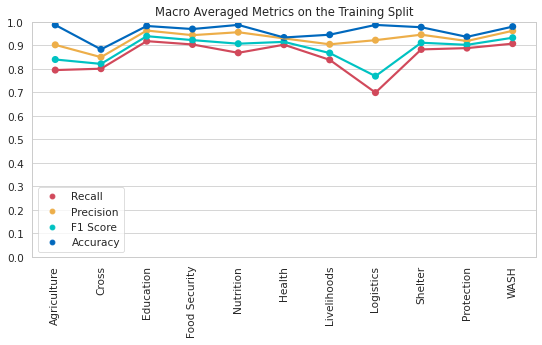

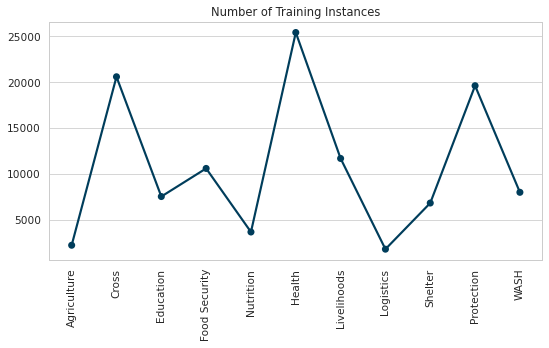

In [27]:
draw_metrics(metrics_train, "Training")
draw_supports(metrics_train, "Training")

In [30]:
metrics_val

,Sector,Precision,Recall,F1 Score,Accuracy,Support
0,Agriculture,0.764247,0.664089,0.701879,0.983024,180
1,Cross,0.739628,0.685807,0.704604,0.814752,2286
2,Education,0.922662,0.827063,0.867463,0.964162,836
3,Food Security,0.883241,0.814458,0.844224,0.941428,1176
4,Nutrition,0.933961,0.822081,0.869002,0.982329,406
5,Health,0.880837,0.849802,0.863321,0.894073,2822
6,Livelihoods,0.842656,0.766304,0.797611,0.919091,1297
7,Logistics,0.835265,0.628818,0.684005,0.981336,219
8,Shelter,0.869017,0.788106,0.822554,0.956021,757
9,Protection,0.866460,0.819424,0.839610,0.898044,2178


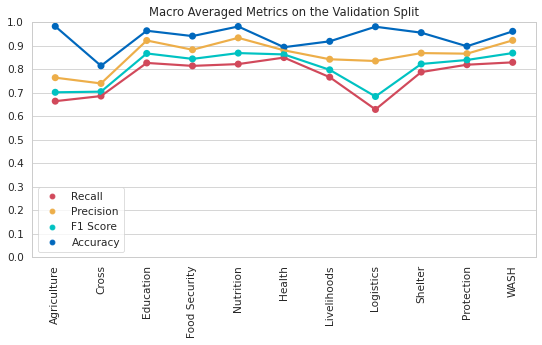

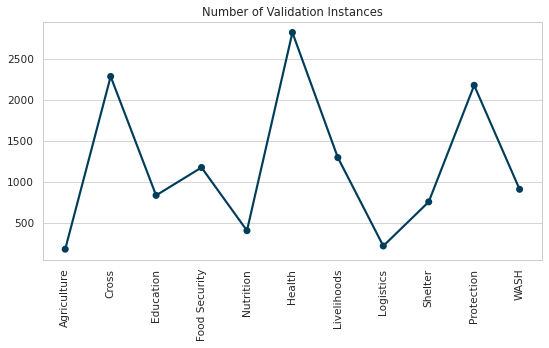

In [29]:
draw_metrics(metrics_val, "Validation")
draw_supports(metrics_val, "Validation")